In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import astropy.constants as const
import astropy.units as u
from astropy.coordinates import SkyCoord
import healpy as hp
import os
import sys
sys.path.insert(0, '/home/aew492/lss-dipoles')
import tools

In [3]:
def EllisBaldwin(x, alpha, v=369.825*u.km/u.s):
    """
    Returns the expected dipole amplitude from Ellis & Baldwin (1984), given
        x = number-count slope at flux density limit
        alpha = source spectral index assuming power law spectra
    """
    return v / const.c.to(u.km/u.s) * (2 + x * (1+alpha))

#### load Quaia catalog

In [4]:
# Quaia map
NSIDE = 64
NPIX = hp.nside2npix(NSIDE)
G = 20.5
cat_fn = f'/scratch/aew492/quasars/catalogs/catalog_G{G}.fits'
tab_quaia = Table.read(cat_fn, format='fits')
map_quaia = tools.load_catalog_as_map(cat_fn, frame='icrs')

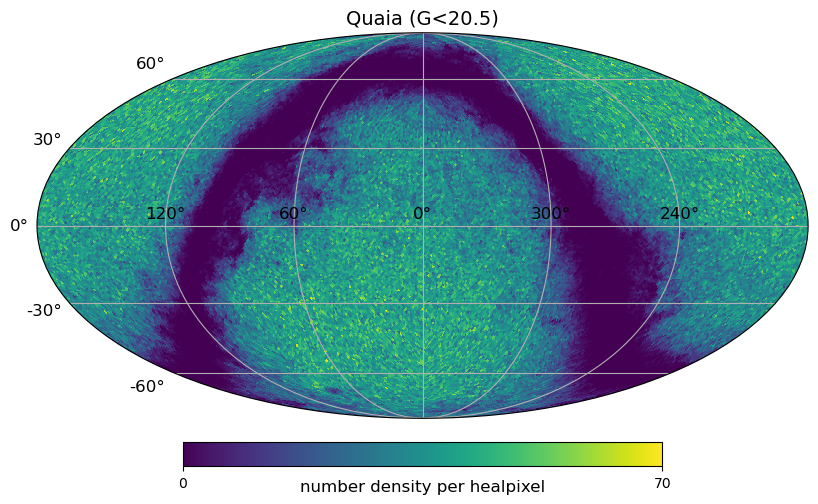

In [5]:
tools.plot_map(map_quaia, title=f'Quaia (G<{G})', unit='number density per healpixel')

### spectral index $\alpha$ distribution

$$
\alpha = -\frac{d\log S_\nu}{d\log\nu}
$$

#### magnitudes $\mathrm{BP}-\mathrm{RP}$

Published Gaia magnitudes are in the Vega system, so we need to convert to AB:

In [6]:
# magnitudes
g = tab_quaia['phot_g_mean_mag']
bp = tab_quaia['phot_bp_mean_mag']
rp = tab_quaia['phot_rp_mean_mag']

In [7]:
def Vega_to_AB(BR_Vega, offset=-0.3250):  # offset computed from Gaia photometric zero points
                                    # (Tables 5.2-5.3 in https://gea.esac.esa.int/archive/documentation/GDR2/ \
                                    # Data_processing/chap_cu5pho/sec_cu5pho_calibr/ssec_cu5pho_calibr_extern.html )
    return BR_Vega + offset

In [8]:
def compute_alpha(B, R, lambda_B=505.15, lambda_R=772.62):
    """
    Compute the spectral slope alpha for a source with given BP and RP magnitudes.
    PARAMETERS:
    - B = BP magnitude (Vega system)
    - R = RP magnitude (Vega system)
    - lambda_B = wavelength (nm) of blue passband (default is the "pivot wavelength" given by Gaia)
    - lambda_R = wavelength (nm) of red passband (")
    """
    # convert given (B-R)_Vega to AB color (B-R)_AB
    BR_AB = Vega_to_AB(B-R)
    
    alpha = BR_AB/(2.5*np.log10(lambda_R/lambda_B))

    return alpha

In [9]:
alphas = [compute_alpha(bp[i], rp[i]) for i in range(len(tab_quaia))]

In [10]:
# load in S21 alpha distribution
S21_alphas = np.load('S21_alphas.npy')

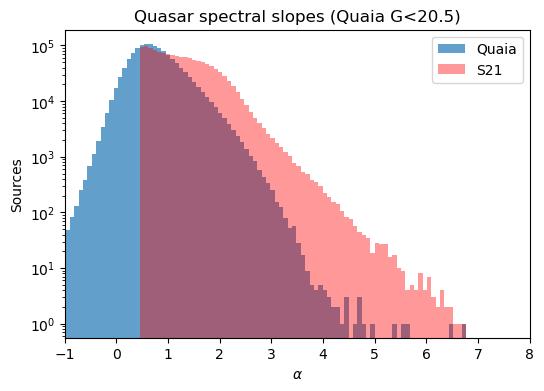

In [11]:
# plot distribution
fig, ax = plt.subplots(figsize=(6,4))

n, bins, _ = ax.hist(alphas, bins=120, alpha=0.7, label='Quaia')
_, _, _ = ax.hist(S21_alphas, bins=bins, alpha=0.4, color='r', label='S21')
ax.set_xlim((-1,8))
ax.set_yscale('log')
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel('Sources')
ax.set_title(f'Quasar spectral slopes (Quaia G<{G})')
ax.legend()

In [12]:
np.mean(alphas), np.mean(S21_alphas)

(0.7737076968903153, 1.2570238304804777)

### number-count slope $x$

$$
x\equiv -\left.\frac{d\ln N(>S_\nu)}{d\ln S_\nu}\right|_{S_\mathrm{min}}
$$

We'll estimate the number-count slope at $G=20.5$ as $(x_{20.6}-x_{20.4})0.2$

In [13]:
cat_fn_6 = '/scratch/aew492/quasars/catalogs/gaia_candidates_clean.fits'
tab_quaia_6 = Table.read(cat_fn_6, format='fits')
g6 = tab_quaia_6['phot_g_mean_mag']

In [14]:
max(g6)

20.599998

In [15]:
# count the number of sources in bins of magnitude
width = 0.1
min_g = 18
max_g = 20.6
nmags = int((max_g-min_g)/width)+1
mags = np.linspace(min_g, max_g, nmags)
counts = np.array([np.sum(g6<=mag) for mag in mags])

Text(0.5, 1.0, 'Quaia (G<20.6) G number counts')

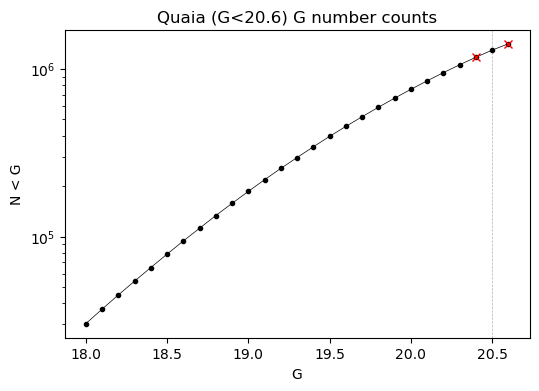

In [18]:
fig, ax = plt.subplots(figsize=(6,4))

ax.plot(mags, counts, 'k.-', lw=0.5)
ax.axvline(20.5, color='k', alpha=0.3, ls='--', lw=0.5)
ax.plot(mags[-1], counts[-1], marker='x', color='r')
ax.plot(mags[-3], counts[-3], marker='x', color='r')

ax.set_yscale('log')
ax.set_xlabel('G')
ax.set_ylabel('N < G')
ax.set_title('Quaia (G<20.6) G number counts')

In [19]:
# slope of interest:
dlogN = np.log10(counts[-1])-np.log10(counts[-3])
dmags = mags[-1]-mags[-3]
x = 2.5*(dlogN)/dmags
x

1.0080084138836356

### expected dipole

In [20]:
EllisBaldwin(x, np.mean(alphas))

<Quantity 0.00467278>

### healpy fit

#### remove zeros from the fit

In [21]:
map_quaia_tofit = np.copy(map_quaia).astype(float)
map_quaia_tofit[map_quaia==0.] = hp.UNSEEN
map_nodip, monopole, dipole = hp.pixelfunc.remove_dipole(map_quaia_tofit, fitval=True)

In [22]:
dipole/monopole

array([-0.04590538,  0.02679215,  0.03439515])

In [23]:
amp = np.linalg.norm(dipole/monopole)
direction = hp.vec2dir(dipole)
ra = direction[1]
dec = np.pi/2 - direction[0]
print(amp)
coord = SkyCoord(ra, dec, unit='rad', frame='icrs')
coord.galactic

0.06330994917462876


<SkyCoord (Galactic): (l, b) in deg
    (193.35410213, 52.4704627)>

#### include zeros in the fit

In [25]:
map_nodip, monopole, dipole = hp.pixelfunc.remove_dipole(map_quaia.astype('float'), fitval=True)
print(dipole/monopole)
amp = np.linalg.norm(dipole/monopole)
direction = hp.vec2dir(dipole)
ra = direction[1]
dec = np.pi/2 - direction[0]
print(amp)
coord = SkyCoord(ra, dec, unit='rad', frame='icrs')
coord.galactic

[-0.06700545  0.04889323  0.01617867]
0.08451051647543525


<SkyCoord (Galactic): (l, b) in deg
    (222.39105954, 41.34865612)>

#### include selection function

In [30]:
selfunc = tools.flatten_map(Table.read(
    f'/scratch/aew492/quasars/maps/selection_function_NSIDE{NSIDE}_G{G}.fits', format='fits'))
map_quaia_expected = map_quaia / selfunc

/state/partition1/job-35984781/ipykernel_2760634/1712354973.py:3: RuntimeWarning: invalid value encountered in divide
  map_quaia_expected = map_quaia / selfunc


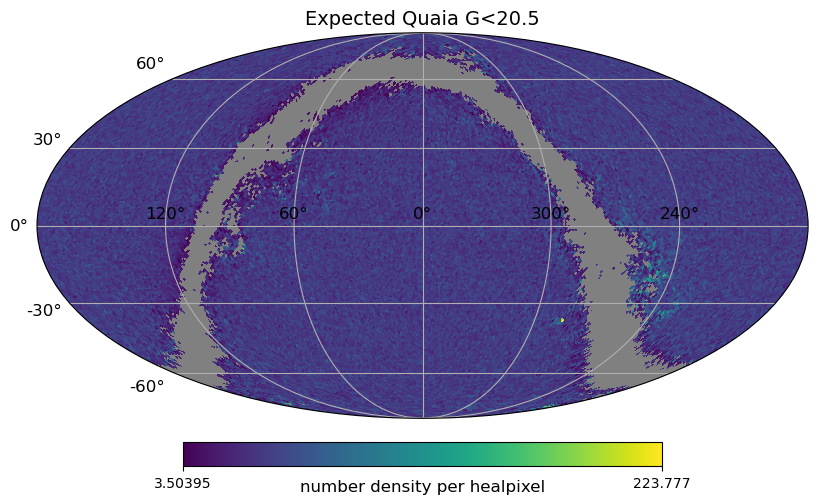

In [31]:
tools.plot_map(map_quaia_expected, title=f'Expected Quaia G<{G}', unit='number density per healpixel')

In [32]:
map_quaia_expected_tofit = np.copy(map_quaia_expected).astype('float')
map_quaia_expected_tofit[map_quaia_expected_tofit==0.] = hp.UNSEEN
map_nodip, monopole, dipole = hp.pixelfunc.remove_dipole(map_quaia_expected_tofit, fitval=True)
print(dipole/monopole)
amp = np.linalg.norm(dipole/monopole)
direction = hp.vec2dir(dipole)
ra = direction[1]
dec = np.pi/2 - direction[0]
print(amp)
coord = SkyCoord(ra, dec, unit='rad', frame='icrs')
coord.galactic

[-0.02597085 -0.06618443 -0.03313192]
0.07843843219389852


<SkyCoord (Galactic): (l, b) in deg
    (353.82681538, 15.17749753)>

#### cut around the galactic plane?

In [36]:
galmask = tools.get_galactic_mask(blim=30, NSIDE=NSIDE, frame='icrs')
map_quaia_galcut = map_quaia_expected * galmask
map_quaia_galcut_tofit = np.copy(map_quaia_galcut).astype('float')
map_quaia_galcut_tofit[map_quaia_galcut_tofit==0.] = hp.UNSEEN

In [38]:
map_nodip, monopole, dipole = hp.pixelfunc.remove_dipole(map_quaia_galcut_tofit, fitval=True)
print(dipole/monopole)
amp = np.linalg.norm(dipole/monopole)
direction = hp.vec2dir(dipole)
ra = direction[1]
dec = np.pi/2 - direction[0]
print(amp)
coord = SkyCoord(ra, dec, unit='rad', frame='icrs')
coord.galactic

[-0.01464103 -0.01524666 -0.00883484]
0.02291015067947531


<SkyCoord (Galactic): (l, b) in deg
    (339.02612023, 30.69526379)>